In [64]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

%matplotlib inline

A receiver operating characteristic (ROC), or simply ROC curve, is a graphical plot which illustrates the performance of a binary classifier system as its discrimination threshold is varied. It is created by plotting the fraction of true positives out of the positives (TPR = true positive rate) vs. the fraction of false positives out of the negatives (FPR = false positive rate), at various threshold settings. TPR is also known as sensitivity, and FPR is one minus the specificity or true negative rate.

ROC curves are typically used in binary classification to study the output of a classifier. In order to extend ROC curve and ROC area to multi-class or multi-label classification, it is necessary to binarize the output. One ROC curve can be drawn per label, but one can also draw a ROC curve by considering each element of the label indicator matrix as a binary prediction (micro-averaging).
Another evaluation measure for multi-class classification is macro-averaging, which gives equal weight to the classification of each label.

In [2]:
# Import some data to play with
iris = datasets.load_iris()
X = iris.data
y = iris.target

print(X[0:4, :])
print('-----')
print(y[0:4])

[[ 5.1  3.5  1.4  0.2]
 [ 4.9  3.   1.4  0.2]
 [ 4.7  3.2  1.3  0.2]
 [ 4.6  3.1  1.5  0.2]]
-----
[0 0 0 0]


In [3]:
# Binarize the output
y = label_binarize(y, classes=[0, 1, 2])
n_classes = y.shape[1]

In [4]:
# Add noisy features to make the problem harder
random_state = np.random.RandomState(0)
n_samples, n_features = X.shape
X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

In [5]:
# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5, random_state=0)

print(y_train[0:4, :])

[[1 0 0]
 [0 0 1]
 [0 1 0]
 [1 0 0]]


In [14]:
# Learn to predict each class against the other
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True, random_state=random_state))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

In [15]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [16]:
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [59]:
y_score.ravel().shape

(225,)

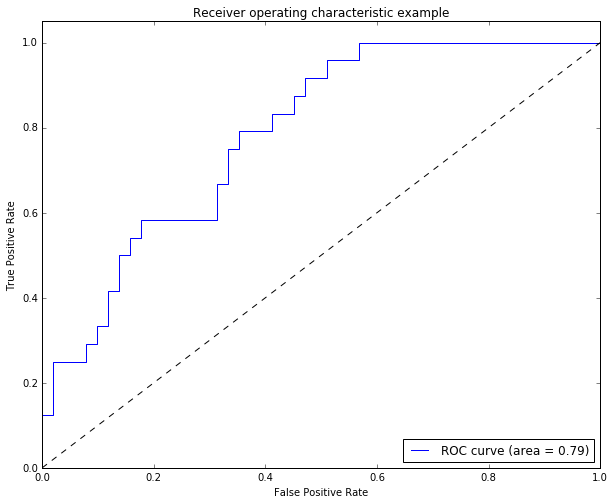

In [28]:
# Plot of a ROC curve for a specific class
plt.figure(figsize=(10,8))
plt.plot(fpr[2], tpr[2], label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [60]:
# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

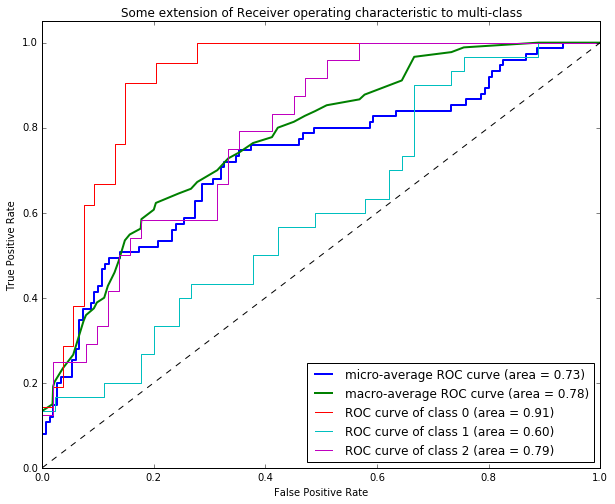

In [61]:
# Plot all ROC curves
plt.figure(figsize=(10,8))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         linewidth=2)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         linewidth=2)

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [49]:
y_test[:, 0]

array([0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 1, 1, 0])

In [50]:
y_score[:, 0]

array([-0.76305896, -0.20238399,  0.11808492, -0.90750303, -0.01108555,
       -0.60521037,  0.02264569, -0.61115098, -0.37590649, -0.47019698,
       -0.42194767, -0.33545871, -0.22711497, -0.07836815, -0.533757  ,
        0.09973063, -0.71354879, -0.55067912,  0.37989555, -0.11088917,
       -0.70721114, -0.02407429, -0.25004251,  0.12688003, -0.68224184,
       -0.0800568 , -0.03254409, -0.04974597, -0.13003384, -0.19289268,
       -0.36221002, -0.2284516 , -0.06178684, -0.52446923, -0.40029714,
       -0.3511887 , -0.05774206, -1.11908314,  0.19597017, -0.04342577,
       -0.4812135 ,  0.17431275, -0.41431727, -0.01086869,  0.01626312,
       -0.11923774, -0.70843733, -0.77322168, -0.61461496, -0.96335686,
       -0.31000437, -0.31988026, -0.35307167,  0.12141618, -0.66412149,
       -0.55119677, -0.55717268, -0.41121128, -0.49442008,  0.06881717,
       -0.23058968,  0.30309598,  0.17584119, -0.19111926, -0.42896846,
       -0.67758109, -0.32984013, -0.97144386,  0.02097654, -0.08

In [88]:
y = np.array([1, 1, 2, 2])
pred = np.array([0.1, 0.4, 0.35, 0.8])
fpr, tpr, thresholds = metrics.roc_curve(y, pred, pos_label=2)
print(fpr)
print(tpr)
print(thresholds)
# metrics.auc(fpr, tpr)

[ 0.   0.5  0.5  1. ]
[ 0.5  0.5  1.   1. ]
[ 0.8   0.4   0.35  0.1 ]
